# Bài toán minh họa
![](./images/09_00.jpg)

In [1]:
%load_ext autoreload
%autoreload 2

# 1. Đọc dữ liệu

In [2]:
from modules.my_pyspark import *
from pyspark.sql.functions import col
import pyspark.sql.functions as f

In [3]:
spark = MyPySpark(session=True)

In [4]:
data_path = r"./data/5000_points.txt"

In [5]:
data = spark.readFile(data_path, header=False, pSep="\t")

In [6]:
data.show(3)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



# 2. Chuẩn hóa dữ liệu

In [7]:
data = data.select(col('_c0').alias('x'), col('_c1').alias('y'))

In [8]:
data.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



# 3. Chuyển dữ liệu

In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
vec_assember = VectorAssembler(inputCols=data.columns, outputCol='features')
final_data = vec_assember.transform(data)

# 4. Scale dữ liệu
* Do dữ liệu quá lớn, nên khi ta tính khoảng cách giữa các điểm bằng euclid thì có thể dẫn đến tràn vùng nhớ thuộc tính biến

In [11]:
from pyspark.ml.feature import StandardScaler

In [12]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

In [13]:
scalerModel = scaler.fit(final_data)

In [14]:
final_data = scalerModel.transform(final_data)

In [15]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



# 5. Xây dựng model

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [17]:
k_list = []
wssse_list = []
evaluator = ClusteringEvaluator()

for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(final_data)
    # wssse = model.summary.trainingCost(final_data)
    predictions = model.transform(final_data)
    wssse = evaluator.evaluate(predictions)
    k_list.append(k)
    wssse_list.append(wssse)
    print(f'--> With k = {k} then sum squares errors = {wssse}')

--> With k = 2 then sum squares errors = 0.5467566327645105
--> With k = 3 then sum squares errors = 0.5792476589423854
--> With k = 4 then sum squares errors = 0.614662491276157
--> With k = 5 then sum squares errors = 0.5966221781940122
--> With k = 6 then sum squares errors = 0.6567390509816632
--> With k = 7 then sum squares errors = 0.6775383548775464
--> With k = 8 then sum squares errors = 0.581777426534819
--> With k = 9 then sum squares errors = 0.6398953058140555
--> With k = 10 then sum squares errors = 0.7200169951434624


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
def line(a: pd.Series, b: pd.Series, title=""):
        plt.plot(a, b, 'co-')
        plt.xlabel(a.name, color='b', weight='bold')
        plt.ylabel(b.name, color='b', weight='bold')
        plt.title(title, fontsize=18, color='r', weight='bold')
        
        plt.show()

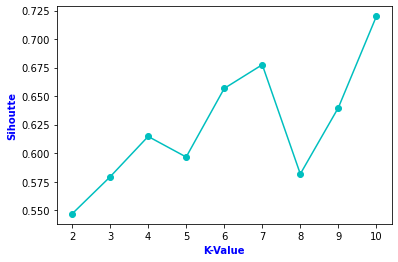

In [20]:
line(pd.Series(k_list, name='K-Value'), pd.Series(wssse_list, name='Sihoutte'))

# 6. Xây dựng model vs K=10

In [21]:
kmeans = KMeans(featuresCol='scaledFeatures', k=10)
model = kmeans.fit(final_data)

In [22]:
centers = model.clusterCenters()

In [23]:
centers

[array([1.50862166, 2.0402761 ]),
 array([3.48538772, 0.66860987]),
 array([2.77092183, 3.63555263]),
 array([3.44772269, 2.67566119]),
 array([3.26634164, 1.38304237]),
 array([1.29983686, 0.70036915]),
 array([1.33679274, 3.4704405 ]),
 array([2.07855338, 0.74821048]),
 array([0.62462026, 1.93898622]),
 array([2.4959137 , 2.04660741])]

In [24]:
predictions = model.transform(final_data)

In [25]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         9|
|         9|
|         9|
|         9|
|         9|
+----------+
only showing top 5 rows



In [26]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  327|
|         6|  652|
|         3|  640|
|         5|  350|
|         9|  616|
|         4|  336|
|         8|  671|
|         7|  353|
|         2|  380|
|         0|  675|
+----------+-----+



In [27]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



In [28]:
temp = final_data.select('scaledFeatures').rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [29]:
temp.show()

+------------------+------------------+
|                _1|                _2|
+------------------+------------------+
| 2.716775610700365| 2.336092297255214|
|2.7236722780340017|2.3658538924649704|
|2.4427660270639544| 2.440366004250274|
|2.5304142423414357|2.3382123709986073|
|2.6003217421823916|2.5782047187507375|
| 2.405652466732943|2.3642553568624516|
|2.3807614698615436| 2.315930395955543|
|2.4734656049636836|2.4362912225154716|
| 2.339913237362317|2.1977235643189017|
|2.4737069474148607| 2.436350584580287|
|2.3632252819260153| 2.491366498221345|
|2.4625642891605155|2.4369060439010557|
| 2.568734514928333|2.4364947495948375|
|2.4840642200653757|2.2767938346525014|
|2.4671947917830996| 2.437215574667591|
|2.7485182788551814|  2.42435096719268|
| 2.504169273413433| 2.418550445430756|
|2.4544609095709933|2.4393992506232864|
| 2.568505444127216| 2.518189671222758|
|2.4623761238595976| 2.562863865143543|
+------------------+------------------+
only showing top 20 rows



# 7. Dự đoán kết quả

In [30]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [31]:
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on='row_index').sort('row_index').drop('row_index')

In [32]:
temp.show()


+------------------+------------------+----------+
|                _1|                _2|prediction|
+------------------+------------------+----------+
| 2.716775610700365| 2.336092297255214|         9|
|2.7236722780340017|2.3658538924649704|         9|
|2.4427660270639544| 2.440366004250274|         9|
|2.5304142423414357|2.3382123709986073|         9|
|2.6003217421823916|2.5782047187507375|         9|
| 2.405652466732943|2.3642553568624516|         9|
|2.3807614698615436| 2.315930395955543|         9|
|2.4734656049636836|2.4362912225154716|         9|
| 2.339913237362317|2.1977235643189017|         9|
|2.4737069474148607| 2.436350584580287|         9|
|2.3632252819260153| 2.491366498221345|         9|
|2.4625642891605155|2.4369060439010557|         9|
| 2.568734514928333|2.4364947495948375|         9|
|2.4840642200653757|2.2767938346525014|         9|
|2.4671947917830996| 2.437215574667591|         9|
|2.7485182788551814|  2.42435096719268|         9|
| 2.504169273413433| 2.41855044

In [33]:
temp = temp.select(col('_1').alias('x_scale'), col('_2').alias('y_scale'), 'prediction')
df = temp.toPandas()

In [34]:
df = temp.toPandas()

centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1
0,1.508622,2.040276
1,3.485388,0.668610
2,2.770922,3.635553
3,3.447723,2.675661
4,3.266342,1.383042


In [35]:
import seaborn as sns

/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


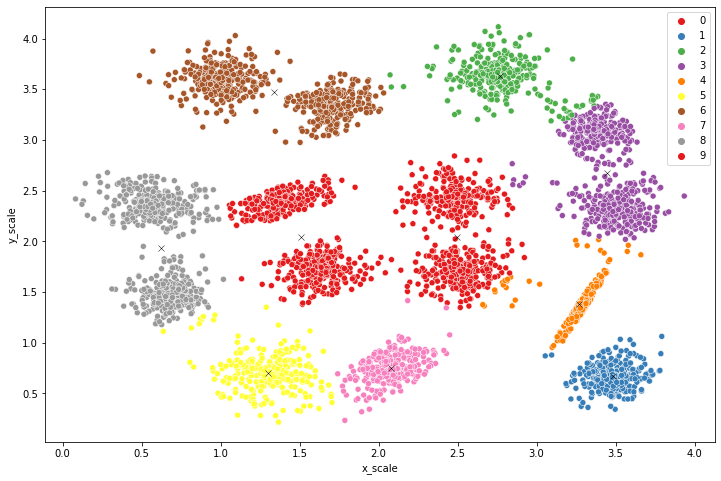

In [36]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x_scale', y='y_scale', data=df, hue='prediction', palette='Set1')
sns.scatterplot(data=centers_df, x=0, y=1, color='black', marker='x')
plt.show()